In [1]:
import numpy as np
from sight_line_constructor import Sightline
import read_cubes
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from astropy.io import ascii

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

from multiprocessing import Pool


from scipy import interpolate
from colossus.cosmology import cosmology

%matplotlib widget


#mpl.rc('text', usetex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

In [2]:
path = "/var/lib/libvirt/images/nbody/baorsd/run101/density_field/"
#cube = read_cubes.read(path+"S020_CIC1024_conf.bin")

In [3]:
files = ascii.read('/home/mata/cosmic-sightlines/simlist.txt',names=["filename", 'redshift'])
files = files[::-1] #lowest redshift first
redshifts = files['redshift'].data

In [4]:
cosmo = FlatLambdaCDM(H0=100, Om0=0.315)
reds = np.linspace(0.,10.,10000)
dist = cosmo.comoving_distance(reds)
z_dist = interpolate.interp1d(reds, dist)
dists = z_dist(redshifts)

params = {'flat': True, 'H0': 100, 'Om0': 0.315, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
cosmo_c = cosmology.setCosmology('myCosmo', params)
growth = cosmo_c.growthFactor(reds)
growth_z = interpolate.interp1d(reds, growth)

growths = growth_z(redshifts)

In [5]:
n_files = len(files)
nc = 1024
L = 2048
res = L/nc


In [6]:

#Function to read in files
l_arr = []
for i in range(len(files)):
    tmp = read_cubes.read(path+str(files[i]['filename']))
    l_arr.append(tmp)



In [7]:
#center of single box is [-L/2,-L/2,-L/2], 
start_point = np.array([0,95,0]) #Mpc/h
end_point = np.array([2500,95,0]) #Mpc/h
#define origin in center of the box
origin = np.array([-L/2,-L/2,-L/2]) #Mpc/h origin of coordinate system


In [8]:
s1 = Sightline(start_point,end_point,origin,periodic=True)

In [9]:
dists

array([   0.        ,  141.80987524,  283.19353311,  424.39312659,
        565.62997617,  707.12042403,  849.05714337,  991.63674372,
       1135.04359213, 1279.45875188, 1425.06900518, 1572.0561105 ,
       1720.60666364, 1870.91593272, 2023.18108248, 2177.61231632,
       2334.43809439, 2493.88159244, 2656.19952512, 2821.67991357,
       2990.59785349])

In [10]:

def los_lightcone(dists,sightline,res) :
    los_arr = []
    range_arr =[]
    los_lightcone = []
    ind_arr = [0]
    for i in l_arr:
        los_arr.append(sightline.calc_los(res,i))
    los_arr = np.asarray(los_arr)
    for i in enumerate(dists[1:]):
        a = np.where(sightline.dist<+i[1])[0].max()
        ind_arr.append(a)    
    a_arr = np.asarray(ind_arr)

    for i in enumerate(a_arr[:-1]):
        range_arr.append(np.arange(a_arr[i[0]],a_arr[i[0]+1]))
        los_lightcone.append(los_arr[i[0]][range_arr[i[0]]])
    los_tot = np.concatenate(los_lightcone).ravel()
    los_tot=np.append(los_tot,los_arr[-1][a_arr[-1]])#hack last entry
    return los_tot


In [11]:
s1_lightcone = los_lightcone(dists,s1,res)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
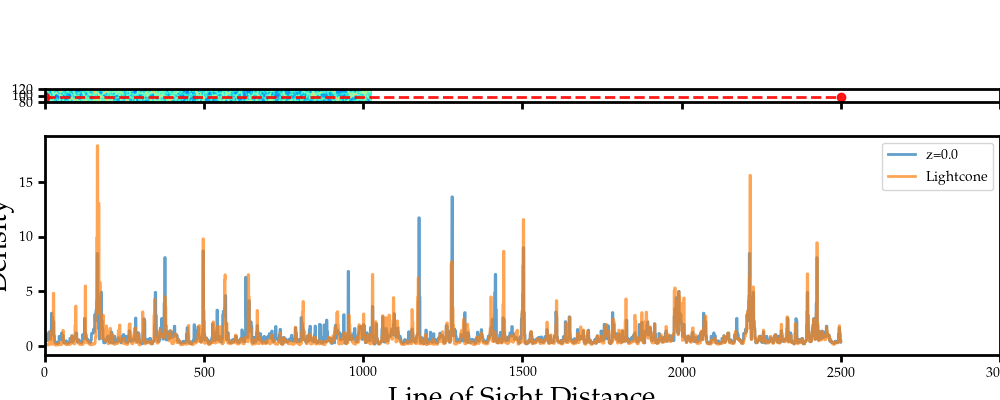

In [12]:
fig, ax = plt.subplots(nrows=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = np.log(l_arr[0][:,:,512]+1)
ax[0].imshow(s.T,vmin=-4,vmax=4,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[0].plot([start_point[0], end_point[0]], [start_point[1],  end_point[1]], 'ro--',lw=2,alpha=0.9)
ax[0].set_xlim(0,3000)
ax[0].set_ylim(80,120)

ax[1].plot(s1.dist,s1.los+1,alpha=0.7,lw=2, label="z="+str(files["redshift"][0]))
ax[1].plot(s1.dist,s1_lightcone+1,alpha=0.7,lw=2,  label="Lightcone")


#ax[1].set_xlim(0,s1.r)
#ax[1].set_ylim(0,15)

ax[1].set_xlabel("Line of Sight Distance",fontsize=20)
ax[1].set_ylabel("Density",fontsize=20)
ax[1].legend()
fig.tight_layout(pad=-1.0)

In [13]:
#create many random end positions and draw sightlines
#reject if they go beyond |r| = dists[-1]
num = 100000
end_points = np.random.uniform(-dists[-1],dists[-1], (num,3) )
iin = np.where(np.linalg.norm((end_points - start_point),axis=1  ) <dists[-1])[0]
end_points  = end_points[iin]


s_arr = []
for i in end_points:
    s_arr.append(Sightline(start_point,i,origin,periodic=True ))

In [14]:
def worker(s):
    res_los = los_lightcone(dists,s,res)
    return res_los



In [18]:
"""
#serial version

result = []

def work_func(end_points):
    s = Sightline(start_point,end_points,origin,periodic=True )
    res_los = los_lightcone(dists,s,res)
    return (res_los)
    
for i in end_points:
    result.append(work_func(i))

"""

'\n#serial version\n\nresult = []\n\ndef work_func(end_points):\n    s = Sightline(start_point,end_points,origin,periodic=True )\n    res_los = los_lightcone(dists,s,res)\n    return (res_los)\n    \nfor i in end_points:\n    result.append(work_func(i))\n\n'

In [15]:
#test parallel
p = Pool(100)
res_los =    p.map(worker,s_arr)



In [16]:
mean = []
var = []
for i in res_los:
    mean.append(i.mean())
    var.append(i.var()) 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
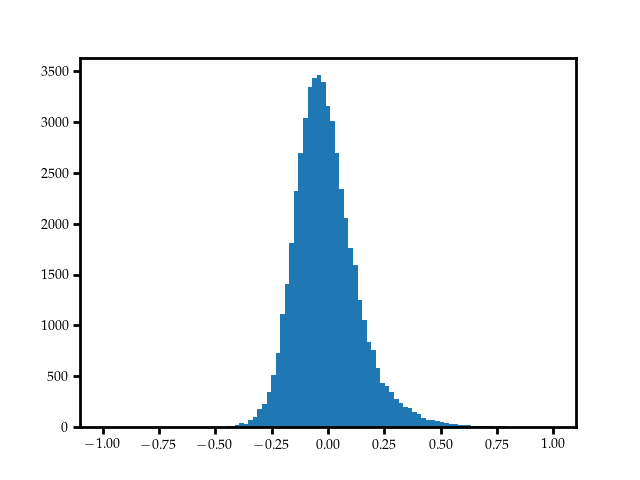

In [17]:
plt.figure()
plt.hist(mean,bins=np.linspace(-1,1,100))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
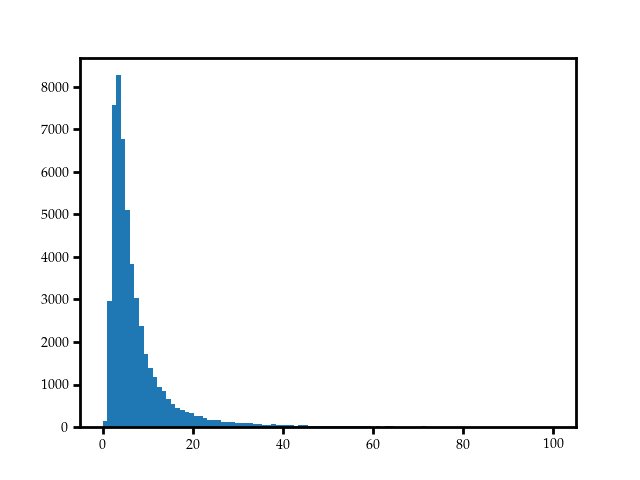

In [18]:
plt.figure()
plt.hist(var,bins=np.linspace(0,100,100))
plt.show()

In [19]:
import glob
phi_files = glob.glob("/home/mata/files/*")[::-1]
phi_arr = []
for i in phi_files:
    tmp = read_cubes.read(i)
    phi_arr.append(tmp)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
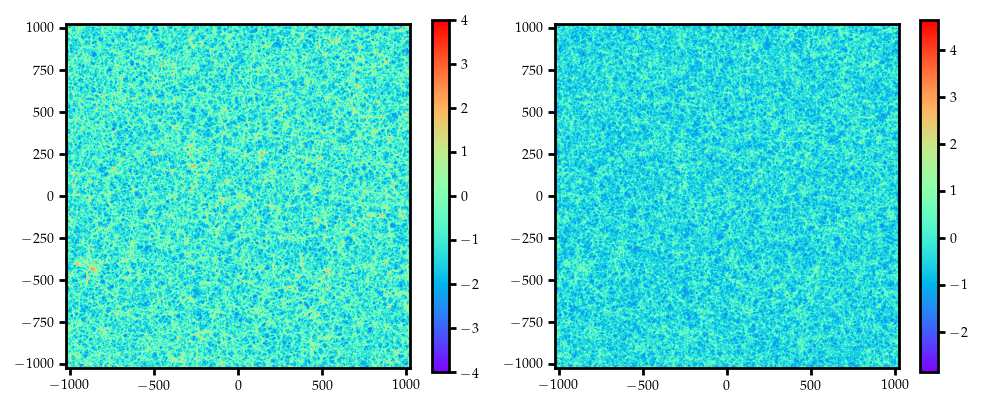

In [63]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = np.log(l_arr[0][:,:,512]+1)
sp = np.log(l_arr[-1][:,:,512]+1)

im0 = ax[0].imshow(s.T,vmin=-4,vmax=4,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
im1 = ax[1].imshow(sp.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")

plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])
plt.tight_layout()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
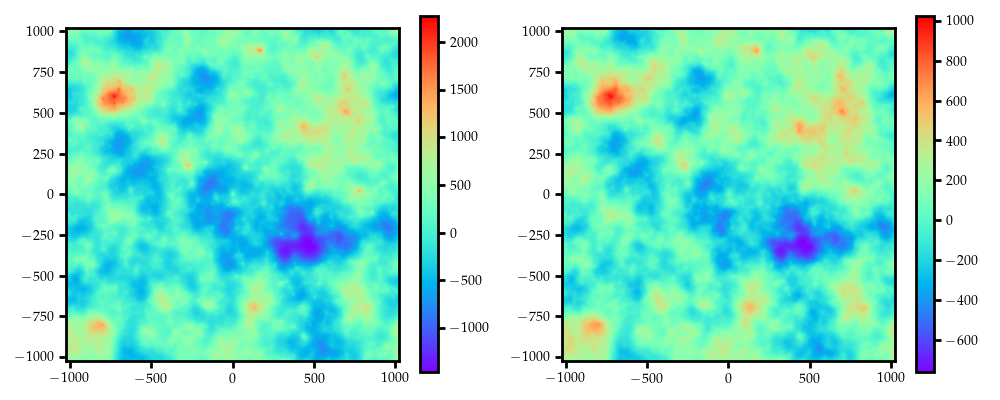

In [64]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = phi_arr[0][:,:,512]+1
sp =  phi_arr[-1][:,:,512]+1

im0 = ax[0].imshow(s.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
im1 = ax[1].imshow(sp.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")

plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = np.log(l_arr[0][:,:,512]+1)
sp = np.log(l_arr[-1][:,:,512]+1)

ax[0].imshow(s.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[1].imshow(sp.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")


In [65]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return k2.astype(np.float16)
k2 = k_box(len(l_arr[0]),len(l_arr[0])*res)


def worker(file):
    delta_k = np.fft.fftn(file)
    delta_kk2 = delta_k /k2
    delta_kk2[0,0,0] =  0
    phi = np.fft.ifftn(delta_kk2)
    phi_r = phi.real 
    return phi_r

In [69]:
obs = np.copy(l_arr[-1])


In [70]:
obs[:,0:400,:] = 0
obs[:,600:,:] = 0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
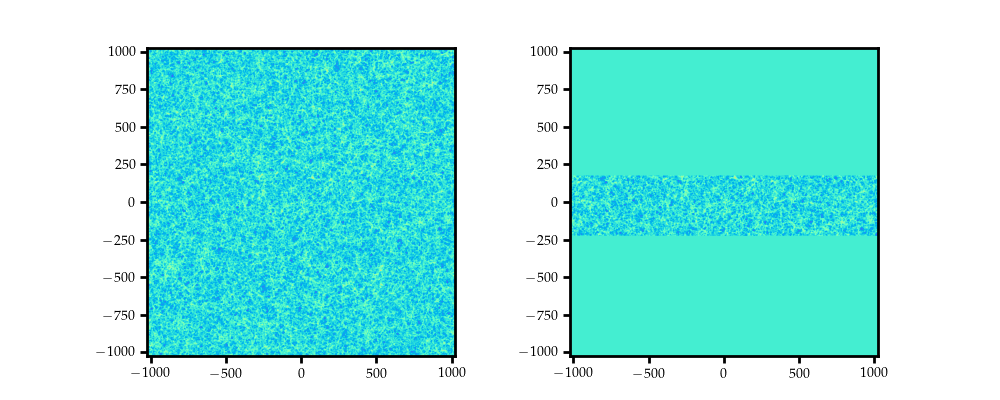

In [72]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = np.log(l_arr[-1][:,:,512]+1)
sp = np.log(obs[:,:,512]+1)

ax[0].imshow(s.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[1].imshow(sp.T,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")


In [73]:
phiobs = worker(obs)

<ipython-input-65-323741356cdc>:13: RuntimeWarning: divide by zero encountered in true_divide
  delta_kk2 = delta_k /k2
<ipython-input-65-323741356cdc>:13: RuntimeWarning: invalid value encountered in true_divide
  delta_kk2 = delta_k /k2


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
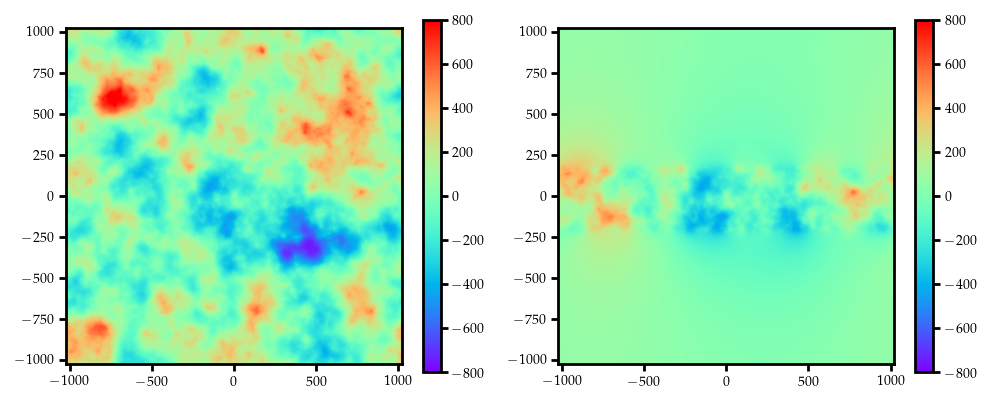

In [81]:
fig, ax = plt.subplots(ncols=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = phi_arr[-1][:,:,512]+1
sp =  phiobs[:,:,512]+1

im0 = ax[0].imshow(s.T,vmin = -800, vmax = 800, origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
im1 = ax[1].imshow(sp.T,vmin = -800, vmax = 800,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")

plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])

plt.tight_layout()

In [112]:
#center of single box is [-L/2,-L/2,-L/2], 
start_point = np.array([-500,0,0]) #Mpc/h
end_point = np.array([950,50,0]) #Mpc/h
#define origin in center of the box
origin = np.array([-L/2,-L/2,-L/2]) #Mpc/h origin of coordinate system
sphi = Sightline(start_point,end_point,origin,periodic=True)

In [113]:
los_full = sphi.calc_los(res,phi_arr[-1])
los_obs = sphi.calc_los(res,phiobs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
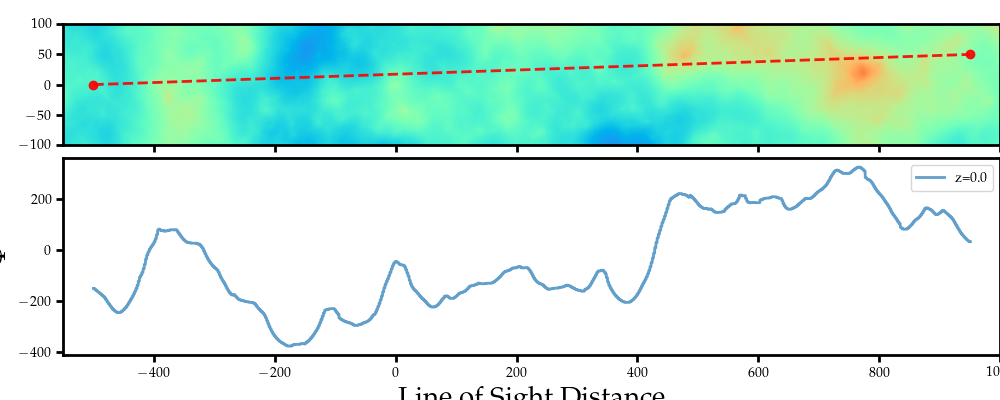

In [117]:
fig, ax = plt.subplots(nrows=2,figsize=(10,4),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = phi_arr[-1][:,:,512]+1
ax[0].imshow(s.T,vmin = -800, vmax = 800,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[0].plot([start_point[0], end_point[0]], [start_point[1],  end_point[1]], 'ro--',lw=2,alpha=0.9)
ax[0].set_xlim(-550,1000)
ax[0].set_ylim(-100,100)

ax[1].plot(sphi.dist-500,los_full+1,alpha=0.7,lw=2, label="z="+str(files["redshift"][0]))
#ax[1].plot(s1.dist,s1_lightcone+1,alpha=0.7,lw=2,  label="Lightcone")

ax[1].set_xlabel("Line of Sight Distance",fontsize=20)
ax[1].set_ylabel("$\Phi$",fontsize=20)
ax[1].legend()
fig.tight_layout(pad=-1.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
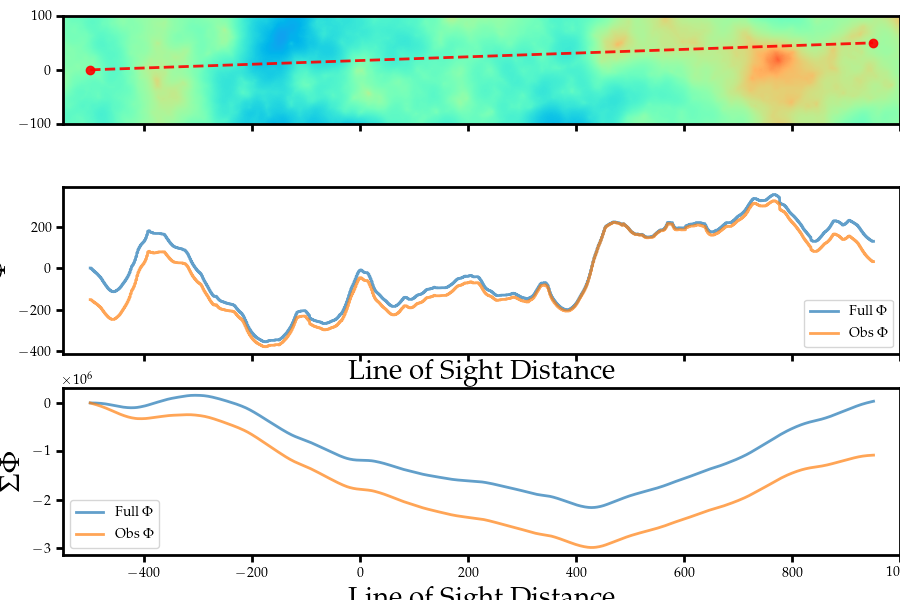

In [121]:
fig, ax = plt.subplots(nrows=3,figsize=(9,6),sharex = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
s = phiobs[:,:,512]+1
ax[0].imshow(s.T,vmin = -800, vmax = 800,origin="lower",aspect="equal", interpolation="bilinear", extent=[-1024,1024,-1024,1024],cmap="rainbow")
ax[0].plot([start_point[0], end_point[0]], [start_point[1],  end_point[1]], 'ro--',lw=2,alpha=0.9)
ax[0].set_xlim(-550,1000)
ax[0].set_ylim(-100,100)

ax[1].plot(sphi.dist-500,los_obs+1,alpha=0.7,lw=2, label="Full $\Phi$")
ax[1].plot(sphi.dist-500,los_full+1,alpha=0.7,lw=2, label="Obs $\Phi$")

ax[1].set_xlabel("Line of Sight Distance",fontsize=20)
ax[1].set_ylabel("$\Phi$",fontsize=20)
ax[1].legend()

ax[2].plot(sphi.dist-500,np.cumsum(los_obs),alpha=0.7,lw=2, label="Full $\Phi$")
ax[2].plot(sphi.dist-500,np.cumsum(los_full),alpha=0.7,lw=2, label="Obs $\Phi$")

ax[2].set_xlabel("Line of Sight Distance",fontsize=20)
ax[2].set_ylabel("$\Sigma \Phi$",fontsize=20)
ax[2].legend()


fig.tight_layout(pad=-1.0)